In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylab as pb
import pandas as pd
import GPy

In [7]:
df = pd.read_csv('fulldf.csv',encoding = 'unicode_escape') 

In [9]:
df2 = df[['_chemical_formula_weight','_space_group_IT_number', '_symmetry_cell_setting', '_symmetry_space_group_name_H-M',
         '_cell_angle_alpha', '_cell_angle_beta', '_cell_angle_gamma', '_diffrn_reflns_theta_full',
         '_diffrn_reflns_theta_max', '_diffrn_reflns_theta_min', '_exptl_absorpt_coefficient_mu',
         '_exptl_absorpt_correction_T_max', '_exptl_absorpt_correction_T_min', 'num_atoms']]

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
space_vals_temp = df2['_symmetry_space_group_name_H-M']
df2['_symmetry_space_group_name_H-M'] = space_vals_temp.astype(str)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df2['_symmetry_space_group_name_H-M'])
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
space_vals_encoded = onehot_encoder.fit_transform(integer_encoded)

 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning:The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.


In [16]:
df2['_symmetry_space_group_name_H-M'] = integer_encoded

 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
sorted_eigs = df['eig']
conv_eigs = []
for val in sorted_eigs:
    temp = []
    eig_str = val[1:-1] # get rid of brackets
    try:
        temp = [float(x) for x in eig_str.split(',')]
    except:
        t = [complex(''.join(a.split())) for a in eig_str.split(',')]  
        temp = [z.real for z in t]
    conv_eigs.append(temp)

In [140]:
xdf = pd.DataFrame.from_records(conv_eigs)

In [141]:
xdf.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,4267.699976,3770.903821,542.644444,375.372003,279.867332,275.628332,149.973042,108.782443,86.692520,78.963480,...,-1.203165,-1.205857,-1.326787,-1.327329,-1.331857,-1.331907,-1.348825,-1.352899,-1.404034,-1.408881
1,982.265858,516.935766,424.237408,396.383803,373.482080,371.779104,362.105303,357.656580,128.857307,112.389082,...,-0.541338,-0.546379,-0.664733,-0.665280,-0.931161,-0.932035,-1.079446,-1.082232,-1.425031,-1.425429
2,486.772036,174.733027,140.112502,113.381146,94.288619,89.498285,81.611886,81.408584,74.768030,71.790340,...,-0.915020,-0.916520,-0.920830,-0.926920,-1.129426,-1.139392,-1.234858,-1.244894,-1.471865,-1.476366
3,918.248218,530.099540,461.672272,427.014639,404.727338,401.977433,364.853972,362.614514,181.223805,133.209662,...,-0.987784,-1.014688,-1.094078,-1.095229,-1.135042,-1.137927,-1.349797,-1.350206,-1.464028,-1.468045
4,466.964435,186.280896,144.011667,131.373156,94.396198,91.667294,90.151252,85.874706,75.512662,73.620526,...,-0.720351,-0.721187,-0.740081,-0.740627,-0.829009,-0.829121,-0.885135,-0.886207,-0.913491,-0.913496


In [177]:
#y = data['Official Time'].str.split(':').apply(lambda x: float(x[0]) * 60.0 + float(x[1]) + float(x[2])/60.0)
#y = conv_eigs
y = df['bandgaps'][:500]
#x = df2[:500]
x = xdf[:500]
y = y.to_numpy()
x = x.to_numpy()

num_pred_data = 10 # how many points to use for plotting predictions
x_pred = np.linspace(1880, 2030, num_pred_data)[:, None] # input locations for predictions

scale = np.max(x) - np.min(x)
loc = np.min(x) + 0.5*scale

In [143]:
# Let's build a covariance matrix based on this function. 
# First we define the form of the covariance function,
def exponentiated_quadratic(x, x_prime, variance, lengthscale):
    squared_distance = ((x-x_prime)**2).sum()
    return variance*np.exp((-0.5*squared_distance)/lengthscale**2)

In [144]:
# We can use this to compute *directly* the covariance for $\mathbf{f}$ at the points given by `x_pred`. 
# Let's define a new function `K()` which does this,

def compute_kernel(X, X2, kernel, **kwargs):
    K = np.zeros((X.shape[0], X2.shape[0]))
    for i in np.arange(X.shape[0]):
        for j in np.arange(X2.shape[0]):
            K[i, j] = kernel(X[i], X2[j], **kwargs)
        
    return K

In [178]:
# Now we can image the resulting covariance,
K = compute_kernel(x_pred, x_pred, exponentiated_quadratic, variance=1., lengthscale=25.)

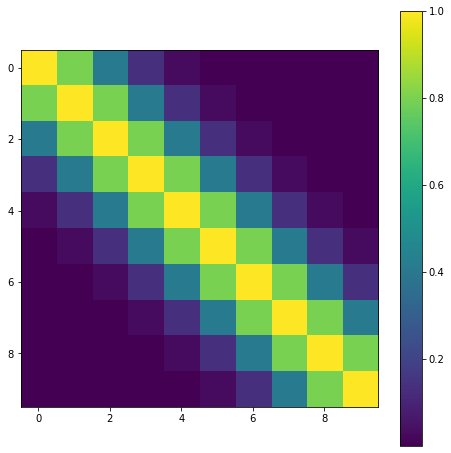

In [179]:
# To visualise the covariance between the points we can use the `imshow` function in matplotlib.
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(K, interpolation='none')
fig.colorbar(im)

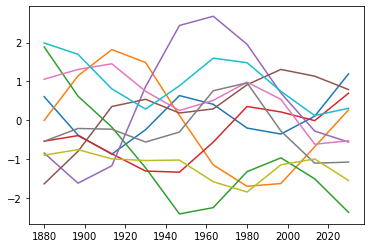

In [180]:
# Finally, we can sample functions from the marginal likelihood.
for i in range(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

In [181]:
class GP():
    def __init__(self, X, y, sigma2, kernel, **kwargs):
        self.K = compute_kernel(X, X, kernel, **kwargs)
        self.X = X
        self.y = y
        self.sigma2 = sigma2
        self.kernel = kernel
        self.kernel_args = kwargs
        self.update_inverse()
    
    def update_inverse(self):
        # Precompute the inverse covariance and some quantities of interest
        ## NOTE: This is not the correct *numerical* way to compute this! It is for ease of use.
        self.Kinv = np.linalg.inv(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # the log determinant of the covariance matrix.
        self.logdetK = np.linalg.det(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # The matrix inner product of the inverse covariance
        self.Kinvy = np.dot(self.Kinv, self.y)
        self.yKinvy = (self.y*self.Kinvy).sum()

        
    def log_likelihood(self):
        # use the pre-computes to return the likelihood
        return -0.5*(self.K.shape[0]*np.log(2*np.pi) + self.logdetK + self.yKinvy)
    
    def objective(self):
        # use the pre-computes to return the objective function 
        return -self.log_likelihood()

In [182]:
# ## Making Predictions
# set covariance function parameters
variance = 0.5
lengthscale = 5
# set noise variance
sigma2 = 0.05

In [183]:
K = compute_kernel(x, x, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)
#K_star = compute_kernel(x, x_pred, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)
#K_starstar = compute_kernel(x_pred, x_pred, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)

In [184]:
# First some helper functions
def sample_covariance(kern, X, num_samps=10):
    """Sample a one dimensional function as if its from a Gaussian process with the given covariance function."""
    from IPython.display import HTML
    display(HTML('<h2>Samples from a Gaussian Process with ' + kern.name + ' Covariance</h2>'))
    display(kern)
    K = kern.K(X) 

    # Generate samples paths from a Gaussian with zero mean and covariance K
    F = np.random.multivariate_normal(np.zeros(X.shape[0]), K, num_samps).T

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(X,F)

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning:cycling among columns of inputs with non-matching shapes is deprecated.


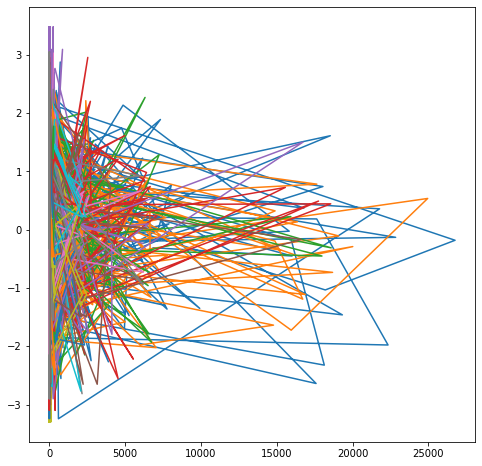

In [186]:
# We are now in a position to define a vector of inputs, a covariance function,
# and then to visualize the samples from the process.

# create an input vector
X = np.linspace(-2, 2, 200)[:, None]

# create a covariance to visualize
kern = GPy.kern.RBF(input_dim=1)

# perform the samples.
#sample_covariance(kern, X)
sample_covariance(kern, x)

poly.,value,constraints,priors
variance,1.0,+ve,
scale,1.0,+ve,
bias,1.0,+ve,


 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:covariance is not positive-semidefinite.
 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning:cycling among columns of inputs with non-matching shapes is deprecated.


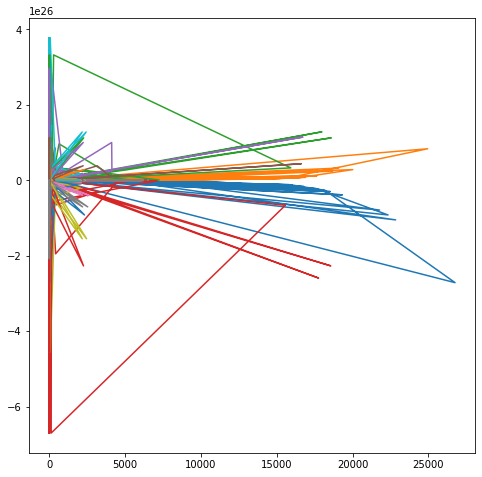

In [187]:
kern = GPy.kern.Poly(input_dim=1, order=6)
sample_covariance(kern, x)

long_term_trend.,value,constraints,priors
variance,4.0,+ve,
lengthscale,0.1,+ve,


 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning:cycling among columns of inputs with non-matching shapes is deprecated.


short_term_trend.,value,constraints,priors
variance,1.0,+ve,
lengthscale,2.0,+ve,


signal.,value,constraints,priors
long term trend.variance,4.0,+ve,
long term trend.timescale,0.1,+ve,
short term trend.variance,1.0,+ve,
short term trend.timescale,2.0,+ve,


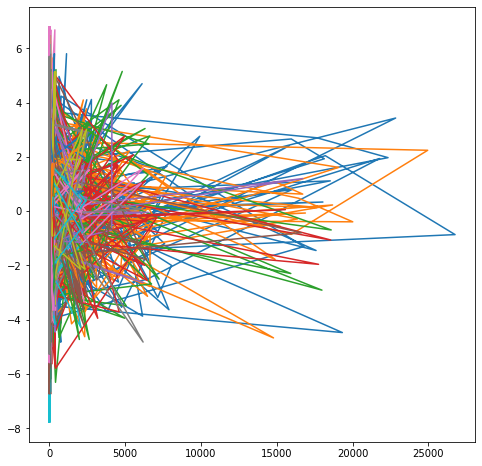

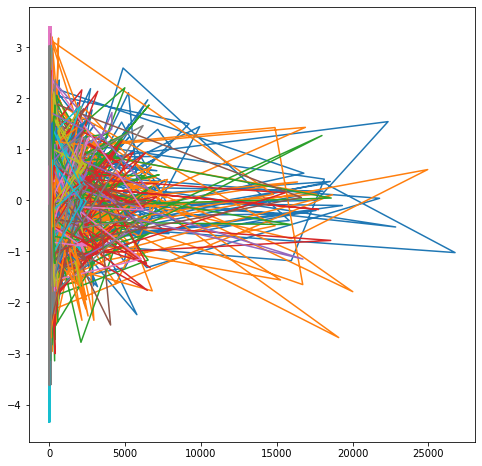

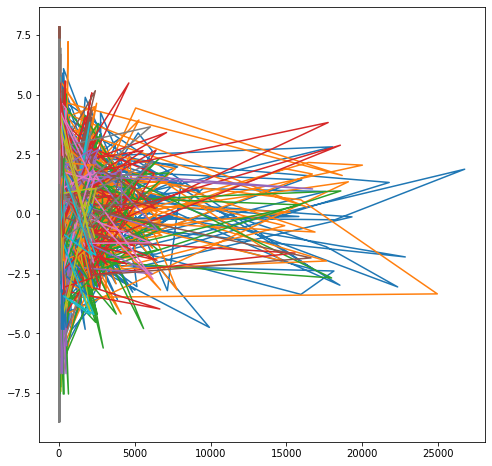

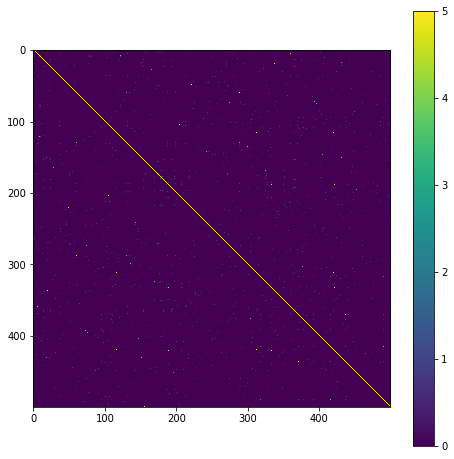

In [155]:
# Combining Covariance Functions 
# Covariance functions can be combined in various ways to make new covariance functions. 
# ### Adding Covariance Functions
k1 = GPy.kern.RBF(1, variance=4.0, lengthscale=0.1, name='long term trend')
k2 = GPy.kern.RBF(1, variance=1.0, lengthscale=2., name='short term trend')
kern = k1 + k2
kern.name = 'signal'
kern.long_term_trend.lengthscale.name = 'timescale'
kern.short_term_trend.lengthscale.name = 'timescale'
# perform the samples.
sample_covariance(k1, x)
sample_covariance(k2, x)
sample_covariance(kern, x)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(kern.K(x), interpolation='none')
plt.colorbar(im)

mul.,value,constraints,priors
linear.variances,1.0,+ve,
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,


linear.,value,constraints,priors
variances,1.0,+ve,


 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning:cycling among columns of inputs with non-matching shapes is deprecated.


rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


mul.,value,constraints,priors
linear.variances,1.0,+ve,
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,


 /Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:covariance is not positive-semidefinite.


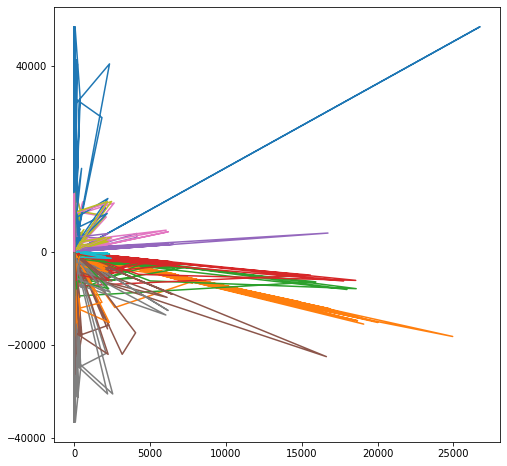

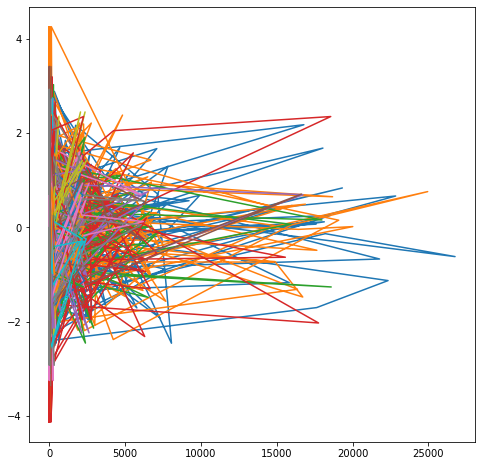

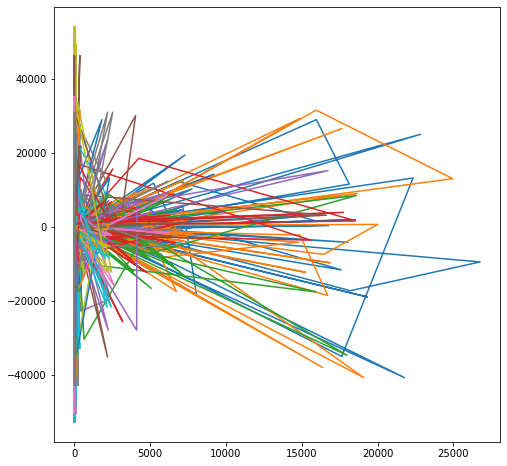

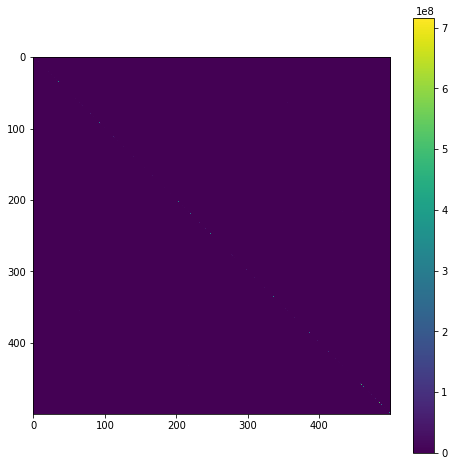

In [156]:
# ### Multiplying Covariance Functions
k1 = GPy.kern.Linear(1)
k2 = GPy.kern.RBF(1)
kern = k1*k2
display(kern)
sample_covariance(k1, x)
sample_covariance(k2, x)
sample_covariance(kern, x)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(kern.K(x), interpolation='none')
plt.colorbar(im)

In [157]:
# ## Improving the Numerics
# 
# In practice we shouldn't be using matrix inverse directly to solve the GP system. 
# One more stable way is to compute the *Cholesky decomposition* of the kernel matrix. 
# The log determinant of the covariance can also be derived from the Cholesky decomposition.

def update_inverse(self):
    # Perform Cholesky decomposition on matrix
    self.R = sp.linalg.cholesky(self.K + self.sigma2*self.K.shape[0])
    # compute the log determinant from Cholesky decomposition
    self.logdetK = 2*np.log(np.diag(self.R)).sum()
    # compute y^\top K^{-1}y from Cholesky factor
    self.Rinvy = sp.linalg.solve_triangular(self.R, self.y)
    self.yKinvy = (self.Rinvy**2).sum()
    
    # compute the inverse of the upper triangular Cholesky factor
    self.Rinv = sp.linalg.solve_triangular(self.R, np.eye(self.K.shape[0]))
    self.Kinv = np.dot(self.Rinv, self.Rinv.T)

GP.update_inverse = update_inverse

In [159]:
# ## Low Rank Approximations
# 
# In the worst case, inference in a Gaussian process is $\mathcal{O}(n^3)$ 
# computational complexity and $\mathcal{O}(n^2)$ storage. For efficient inference in larger 
# data sets we need to consider approximations. One approach is low rank approximation of the 
# covariance matrix (also known as sparse approximations or perhaps more accurately parsimonious 
# approximations). We'll study these approximations by first creating a simple data set by sampling 
# from a GP.

X = np.sort(np.random.rand(50,1)*12,0)
k = GPy.kern.RBF(1)
K = k.K(x)
K+= np.eye(500)*0.01 # add some independence (noise) to K
y = np.random.multivariate_normal(np.zeros(500), K).reshape(500,1)


In [160]:
# Build a straightforward GP model of our simulation. We’ll also plot the posterior of $f$.

m = GPy.models.GPRegression(x,y)
m.optimize()
#fig = pb.figure()
#ax = fig.add_subplot(111)
#m.plot_f(ax=ax)
#get_ipython().run_line_magic('pinfo', 'm._raw_predict')
#mu, var = m._raw_predict(X) # this fetches the posterior of f

#pb.vlines(x[:,0], mu[:,0]-2.*np.sqrt(var[:,0]), mu[:,0]+2.*np.sqrt(var[:,0]),color='r',lw=2)

In [161]:
### Building the Low Rank Approximation
# Now we’ll consider a GP that uses a low rank approximation to fit the data.
"""
Z = np.random.rand(10,1)*12
m = GPy.models.SparseGPRegression(X,y,Z=Z)
print(Z.shape)
print(X.shape)
print(m)
"""
#Z = np.random.rand(10,1)*12 
m = GPy.models.SparseGPRegression(x,y)
print(m)


Name : sparse_gp
Objective : 956.577487624312
Number of Parameters : 2083
Number of Optimization Parameters : 2083
Updates : True
Parameters:
  sparse_gp.               |      value  |  constraints  |  priors
  inducing_inputs          |  (10, 208)  |               |        
  rbf.variance             |        1.0  |      +ve      |        
  rbf.lengthscale          |        1.0  |      +ve      |        
  Gaussian_noise.variance  |        1.0  |      +ve      |        


In [171]:
m

sparse_gp.,value,constraints,priors
inducing inputs,"(10, 208)",,
rbf.variance,3.021015528502598e-08,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0018141388272581,+ve,


<bound method SparseGP.to_dict of <GPy.models.sparse_gp_regression.SparseGPRegression object at 0x1a25c22690>>

TypeError: calculated free_dims [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207] from visible_dims None and fixed_dims [] is neither 1D nor 2D

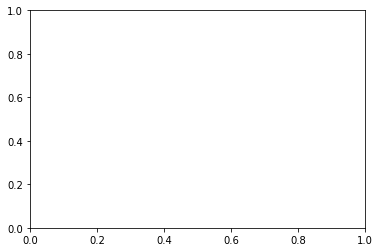

In [162]:

# In GPy, the sparse inputs $\mathbf{Z}$ are abbreviated 'iip' , for inducing input. 
# Plot the posterior
# of $u$ in the same manner as for the full GP:

m.optimize()
fig = pb.figure()
ax = fig.add_subplot(111)
m.plot_f(ax=ax)
get_ipython().run_line_magic('pinfo', 'm._raw_predict')
mu, var = m._raw_predict(Z) 
#pb.vlines(Z[:,0], mu[:,0]-2.*np.sqrt(var[:,0]), mu[:,0]+2.*np.sqrt(var[:,0]),color='r')

##### 